#### Jupyter notebook usage

- To execute a code block (to run a cell) hit: `shift + return` or click on the `Run` button at the top.
- After execution the circle in the top-right corner is filled grey. Once execution has finished the circle will be filled white again.

# Completeness of OpenStreetMap Buildings
We will have a closer look at the buildings mapped in OSM for Berlin (our host city for [FOSSGIS 2023](https://fossgis-konferenz.de/2023/)).

Let's check the following questions:
* What is the temporal evolution of the number of features tagged as `building=* and geometry:polygon and building!=no` in Berlin since 2008?
* How can we estimate the completeness of buildings from their temporal evolution?

## Request the ohsome API
The ohsome API lets you analyze the rich data source of the OpenStreetMap history. You can either perform analyses using a dashboard-like application, or use the ohsome API directly and work with its CSV, JSON or GeoJSON responses.

*Further Resource:* [Website](https://heigit.org/big-spatial-data-analytics-en/ohsome/) | [GitHub](https://github.com/GIScience/ohsome-api) | [API](https://oqt.ohsome.org/api/docs)

<div class="alert alert-block alert-info"><b>Tip:</b> Check <a href="https://giscience.courses-pages.gistools.geog.uni-heidelberg.de/openstreetmap-analyses-with-qgis-python-and-r/content/chapter_2/osm_data_filtering.html">this course material</a> if you need some guidance on how to filter OSM data.</div>

### Let's try it first with the ohsome Dashboard
The [ohsome Dashboard](https://ohsome.org/apps/dashboard/) generates accurate statistics about the historical development of OSM data for custom or predefined regions all over the world and relies on the ohsome API. No programming skills are needed to work with the dashboard. The ohsome Dashboard allows custom filtering of all available OpenStreetMap tags and types and includes administrative boundaries, making the selection of search areas easier. As a result you get a graphical view on the response values of your request.

1. Define your query in the dashboard.
<img src="img/ohsome_dashboard_buildings_query.png" width="75%">

2. Take a look at the results.
<img src="img/ohsome_dashboard_buildings_results.png" width="75%">

### Let's do the same with Python...

In [4]:
import json
from datetime import datetime
import requests

# check the ohsome API documentation for more details on all endpoints
base_url = "https://api.ohsome.org/v1"
endpoint = "/elements/count"
url = base_url + endpoint

with open("germany-berlin.geojson", "r") as file:
    bpolys = json.load(file)

parameters = {
    "bpolys": json.dumps(bpolys),  # pass GeoJSON as string.
    "filter": "building=* and geometry:polygon and building!=no",
    "format": "json",
    "time": "2008-01-01/2022-01-01/P1Y",  # P1Y --> yearly time interval
}
headers = {
    "accept": "application/json",
    "Content-Type": "application/x-www-form-urlencoded",
}
    
response = requests.post(url, data=parameters, headers=headers)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

print(json.dumps(response.json(), indent=4))  # Pretty print response

result = response.json()["result"]

{
    "attribution": {
        "url": "https://ohsome.org/copyrights",
        "text": "\u00a9 OpenStreetMap contributors"
    },
    "apiVersion": "1.9.0",
    "result": [
        {
            "timestamp": "2008-01-01T00:00:00Z",
            "value": 2372.0
        },
        {
            "timestamp": "2009-01-01T00:00:00Z",
            "value": 17906.0
        },
        {
            "timestamp": "2010-01-01T00:00:00Z",
            "value": 39522.0
        },
        {
            "timestamp": "2011-01-01T00:00:00Z",
            "value": 76293.0
        },
        {
            "timestamp": "2012-01-01T00:00:00Z",
            "value": 146518.0
        },
        {
            "timestamp": "2013-01-01T00:00:00Z",
            "value": 172093.0
        },
        {
            "timestamp": "2014-01-01T00:00:00Z",
            "value": 221428.0
        },
        {
            "timestamp": "2015-01-01T00:00:00Z",
            "value": 371846.0
        },
        {
            "timestamp

### ..and plot the results

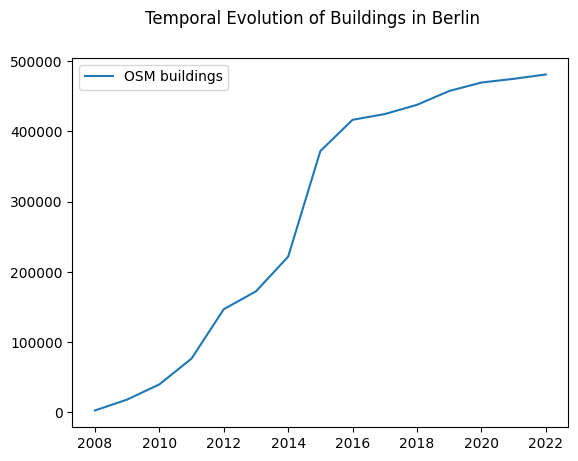

In [7]:
import matplotlib.pyplot as plt


dates = []
values = []
for r in result:
    year = datetime.fromisoformat(r["timestamp"].replace("Z", ""))
    dates.append(year)
    values.append(r["value"])

fig, ax = plt.subplots()
ax.plot(dates, values, label="OSM buildings")
ax.legend()
fig.suptitle("Temporal Evolution of Buildings in Berlin")
plt.show()

## Request the ohsome quality analyst (OQT) API

OQT provides quality estimations of OpenStreetMap (OSM) data and uses the ohsome API.

OQT calls those estimations indicators.
Indicators are computed for a specific area (`bpolys`) and a certain set of aggregated OSM features (`layer`).

OQT offers two intrinsic quality estimation: the "Mapping Saturation" indicator and the "Currentness" indicator.

*Further Resource:* [Website](https://oqt.ohsome.org) | [GitHub](https://github.com/GIScience/ohsome-quality-analyst) | [API](https://docs.ohsome.org/ohsome-api/v1/)

### Mapping Saturation Indicator

The Mapping Saturation indicator calculate the saturation of mapping activity within the last 3 years.
It is based on the premise that each aggregation of features (e.g. length of roads or count of buildings) has a maximum. After increased mapping activity saturation is reached near this maximum.
The Mapping Saturation indicator works well with following layers:

- Building Count (`building_count`)
- Amenities (`amenities`)
- Point-of-Interests (`poi`)

In [8]:
# Helper function to display OQT API response.

import json

from IPython.display import SVG, display
import requests
from termcolor import colored


def display_results(feature):
    name = feature["properties"]["name"]
    label = feature["properties"]["result"]["label"]
    color = feature["properties"]["result"]["label"]
    description = feature["properties"]["result"]["description"]
    svg = feature["properties"]["result"]["svg"]

    # print(json.dumps(result, indent=4))
    print(name)
    print("-" * len(name))
    print("Quality Label: " + colored(label, color))
    print("Result Description: " + description)
    display(SVG(svg))

Berlin
------
Quality Label: green
Result Description: The saturation of the last 3 years is 98.75%.
High saturation has been reached (97% < Saturation ≤ 100%).



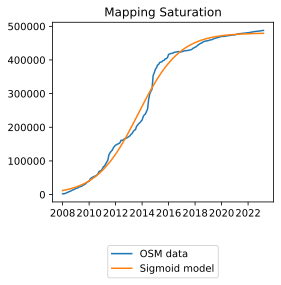

In [9]:
import json
import requests


base_url = "https://oqt.ohsome.org/api"
endpoint = "/indicator"
url = base_url + endpoint

with open("germany-berlin.geojson", "r") as file:
    bpolys = json.load(file)

parameters = {
    "name": "MappingSaturation",
    "layerKey": "building_count",
    "bpolys": bpolys,
    "includeSvg": True,
}

response = requests.post(url, json=parameters)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

display_results(response.json())

### Mapping Saturation Indicator for all districts in Berlin

The previous requests have been about one Area-of-Interest (AOI). OQT can compute the same Indicator for a number of AOIs given a GeoJSON FeatureCollection.

Lichtenberg
-----------
Quality Label: yellow
Result Description: The saturation of the last 3 years is 94.93%.
Saturation is in progress (30% < Saturation ≤ 97%).



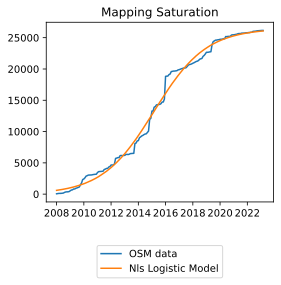

Charlottenburg-Wilmersdorf
--------------------------
Quality Label: yellow
Result Description: The saturation of the last 3 years is 92.57%.
Saturation is in progress (30% < Saturation ≤ 97%).



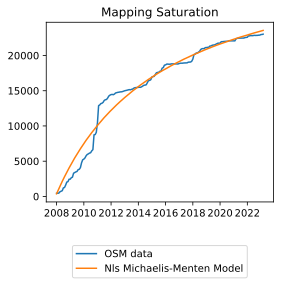

Pankow
------
Quality Label: green
Result Description: The saturation of the last 3 years is 100.0%.
High saturation has been reached (97% < Saturation ≤ 100%).



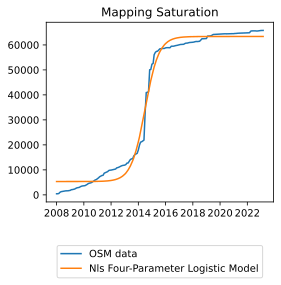

Marzahn-Hellersdorf
-------------------
Quality Label: green
Result Description: The saturation of the last 3 years is 99.92%.
High saturation has been reached (97% < Saturation ≤ 100%).



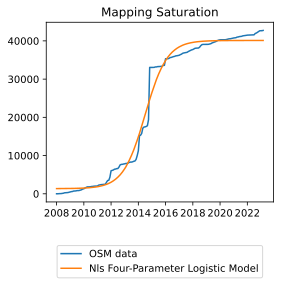

Neukölln
--------
Quality Label: green
Result Description: The saturation of the last 3 years is 99.3%.
High saturation has been reached (97% < Saturation ≤ 100%).



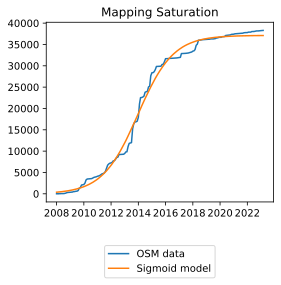

Tempelhof-Schöneberg
--------------------
Quality Label: green
Result Description: The saturation of the last 3 years is 99.8%.
High saturation has been reached (97% < Saturation ≤ 100%).



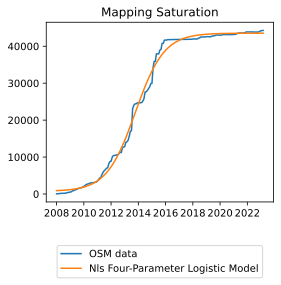

Friedrichshain-Kreuzberg
------------------------
Quality Label: yellow
Result Description: The saturation of the last 3 years is 95.3%.
Saturation is in progress (30% < Saturation ≤ 97%).



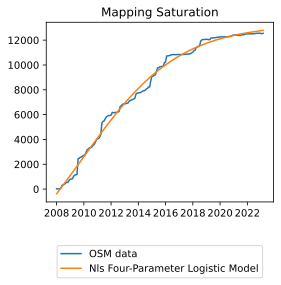

Treptow-Köpenick
----------------
Quality Label: green
Result Description: The saturation of the last 3 years is 99.2%.
High saturation has been reached (97% < Saturation ≤ 100%).



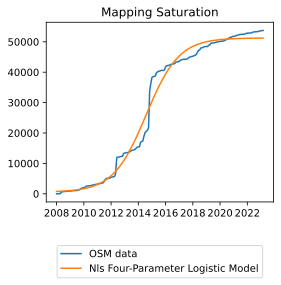

Steglitz-Zehlendorf
-------------------
Quality Label: green
Result Description: The saturation of the last 3 years is 99.0%.
High saturation has been reached (97% < Saturation ≤ 100%).



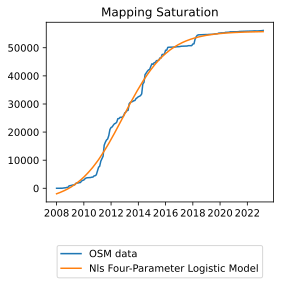

Mitte
-----
Quality Label: yellow
Result Description: The saturation of the last 3 years is 92.16%.
Saturation is in progress (30% < Saturation ≤ 97%).



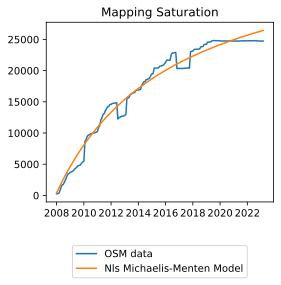

Spandau
-------
Quality Label: green
Result Description: The saturation of the last 3 years is 99.16%.
High saturation has been reached (97% < Saturation ≤ 100%).



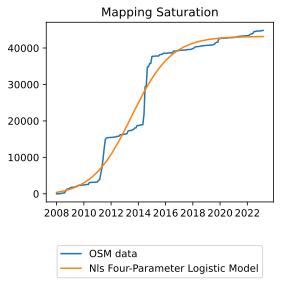

Reinickendorf
-------------
Quality Label: green
Result Description: The saturation of the last 3 years is 98.81%.
High saturation has been reached (97% < Saturation ≤ 100%).



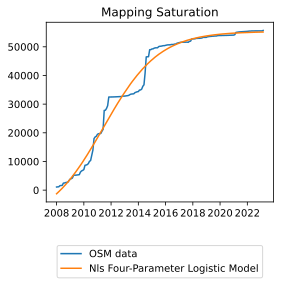

In [10]:
import json
import requests


base_url = "https://oqt.ohsome.org/api"
endpoint = "/indicator"
url = base_url + endpoint

# load districts as GeoJSON FeatureCollection
with open("germany-berlin-districts.geojson", "r") as file:
    bpolys = json.load(file)

parameters = {
    "name": "MappingSaturation",
    "layerKey": "building_count",
    "bpolys": bpolys,
    "includeSvg": True,
}

response = requests.post(url, json=parameters)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

features = response.json()["features"]
for feature in features:
    display_results(feature)